# Pipeline for the anomaly detection on the SKAB using MSET

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [ ]:
# libraries importing
import math
import sys
import warnings

import numpy as np
import pandas as pd

sys.path.append("..")
from core.MSET import MSET
from core.metrics import chp_score
from core.utils import load_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

### Method initialization

In [ ]:
def movmean(array, window):
    n = np.size(array)
    xx = array.copy()
    y = []
    for i in range(0, window):
        y.append(np.roll(xx.tolist() + [np.nan] * window, i))
    y = np.nanmean(y, axis=0)
    window_ceil = math.ceil(window / 2)

    return y[window_ceil - 1 : n + window_ceil - 1]

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
rel_errors = []
x = 0
for df in list_of_df:
    x += 1
    df = df.drop(["anomaly", "changepoint"], axis=1)
    train_stop = 400

    ms = MSET()
    ms.fit(df[:train_stop])

    # results predicting
    Y_pred = ms.predict(df)
    err = np.linalg.norm(df - Y_pred, axis=1)
    rel_err = movmean(err / np.linalg.norm(Y_pred, axis=1), window=60)
    rel_errors.append(rel_err)

    UCL = 0.01
    prediction = (
        pd.DataFrame((rel_err > UCL), df.index)
        .fillna(0)
        .any(axis=1)
        .astype(int)
    )

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

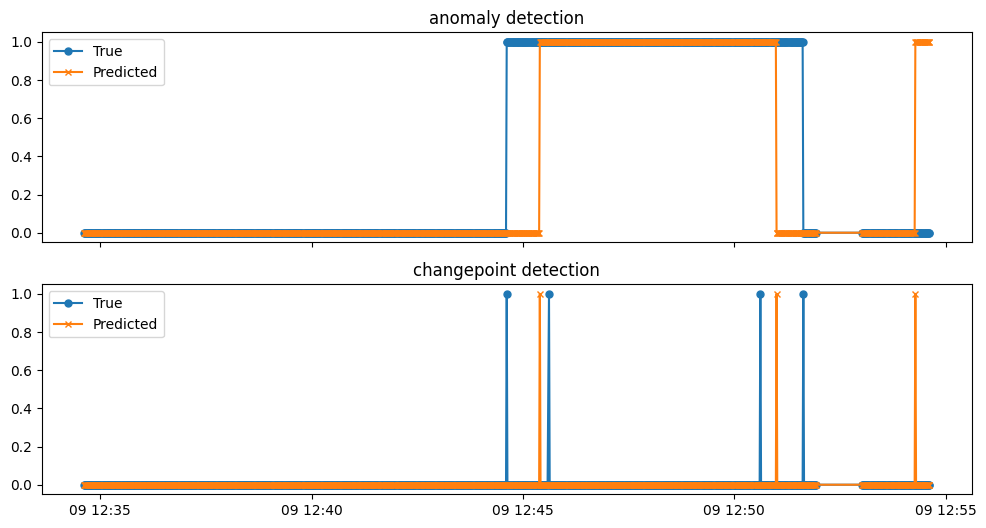

In [ ]:
# [donotremove]
true_outlier = [df.anomaly for df in list_of_df]
true_cp = [df.changepoint for df in list_of_df]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 17.93 %
Missing Alarm Rate 16.08 %
F1 metric 0.77


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 94
A number of FPs = 19
Average time 0 days 00:00:50.022857142


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  5.97
LowFP  -  1.84
LowFN  -  7.86
